In [1]:
from torch.utils.data import Dataset
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import json
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import cv2
import numpy as np
from functions import *

In [2]:
#Image Folder
IMAGE_PATH = 'images'
MASK_PATH = 'metadata.json'
imageFiles = [f for f in listdir(IMAGE_PATH) if isfile(join(IMAGE_PATH, f))]

#Metadata FOlder
f = open(MASK_PATH)
maskJSON = json.load(f)

In [3]:
def getJSONMask(fileName):
    points = []
    for point in maskJSON[fileName]['bounds_x_y']:
        points.append((point['x'],point['y']))
    MaxMin = getMaxAndMin(points)

    rectangleSize = (int(MaxMin[2])+2-int(MaxMin[0]),(int(MaxMin[3])+2-int(MaxMin[1])))
    mask = np.zeros(rectangleSize,dtype='int')

    polygon = Polygon(points)
    for x in range(int(MaxMin[0]),int(MaxMin[2])+2):
        for y in range(int(MaxMin[1]),int(MaxMin[3])+2):
            if polygon.contains(Point(x,y)):
                xPoint = x-int(MaxMin[0])
                yPoint = y-int(MaxMin[1])
                mask[xPoint,yPoint]=1
    
    mask = np.transpose(mask)

    return {'minX':int(MaxMin[0]),'minY':int(MaxMin[1]),'mask':mask}



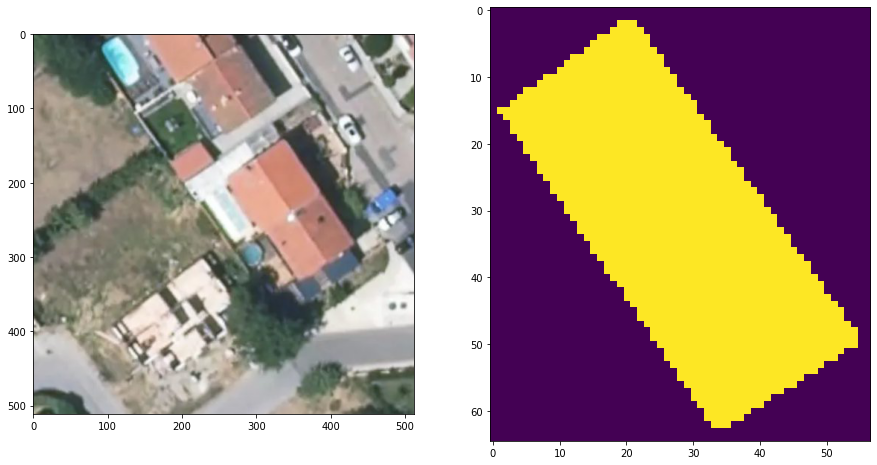

In [4]:
idx = 9
JSONMask = getJSONMask(imageFiles[idx])

image = cv2.imread(join(IMAGE_PATH,imageFiles[idx]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
plt.imshow(image)
fig.add_subplot(1,2,2)
plt.imshow(JSONMask['mask'])


In [5]:
def getMASKfromJSON(json):
    smallMask = json['mask']
    mask = np.zeros((512,512),dtype='int')
    print(json['minY'],len(smallMask))
    for y in range(len(smallMask)):
        for x in range(len(smallMask[0])):
            mask[json['minY']+y,json['minX']+x] = smallMask[y][x]
    return(mask)

199 86


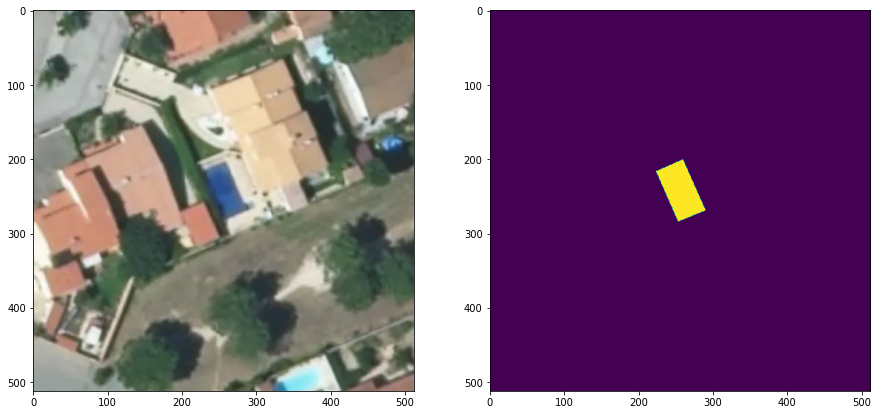

In [6]:
idx = 435

JSONMask = getJSONMask(imageFiles[idx])

m = getMASKfromJSON(JSONMask)
image = cv2.imread(join(IMAGE_PATH,imageFiles[idx]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
plt.imshow(image)
fig.add_subplot(1,2,2)
plt.imshow(m)

In [7]:
from tqdm import tqdm
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

fJSON = open('metadata.json')
maskJSON = json.load(fJSON)
fileNames = list(maskJSON.keys())
imageFiles = [f for f in listdir('images') if isfile(join('images', f))]

createdFiles = [f for f in listdir('masks') if isfile(join('masks', f))]

for i in tqdm(range(len(fileNames))):
    fileOut = fileNames[i][:-4]+'.out'
    if (fileOut not in createdFiles) and (fileNames[i] in imageFiles):
        m = getJSONMask(fileNames[i])
        with open(join('masks',fileOut), 'w') as f:
            json.dump(m, f,cls = NumpyEncoder)


100%|██████████| 14964/14964 [1:02:11<00:00,  4.01it/s]
